In [1]:
from __future__ import print_function
from Bio.PDB import *
import os
import numpy as np
import collections
import pandas as pd
from scipy.spatial import distance
from pygsp import graphs, features
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
from pygsp import utils
from pygsp import graphs, filters
from sklearn.linear_model import LinearRegression

In [2]:
amino_lookup = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','CCS':'C','AC5':'L'}
amino_molecular_mass = {'A': 89.09404, 'R': 174.20274, 'N': 132.11904, 'D': 133.10384, 'C': 121.15404,
                        'Q': 146.14594, 'E': 147.13074, 'G': 75.06714, 'H': 155.15634, 'I': 131.17464,
                        'L': 131.17464, 'K': 146.18934, 'M': 149.20784, 'F': 165.19184, 'P': 115.13194,
                        'S': 105.09344, 'T': 119.12034, 'W': 204.22844, 'Y': 181.19124, 'V': 117.14784}
amino_hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

amino_bulkiness = {'A':11.5, 'D':11.68,'C':13.46,'E':13.57,'F':19.8,'G':3.4,'H':13.67,'I':21.4,'K':15.71,'L':21.4,
                   'M':16.25,'N':12.82,'P':17.43,'Q':14.45,'R':14.28,'S':9.47,'T':15.77,'V':21.57,'W':21.61,'Y':18.03}

amino_polarity = {'A':0, 'D':49.7,'C':1.48,'E':49.9,'F':0.35,'G':0,'H':51.6,'I':0.1,'K':49.5,'L':0.13,
                   'M':1.43,'N':3.38,'P':1.58,'Q':3.53,'R':52,'S':1.67,'T':1.66,'V':0.13,'W':2.1,'Y':1.61}

amino_turn_tendency = {'A':0.66, 'D':1.46,'C':1.19,'E':0.74,'F':0.6,'G':1.56,'H':0.95,'I':0.47,'K':1.01,'L':0.59,
                   'M':0.6,'N':1.56,'P':1.52,'Q':0.98,'R':0.95,'S':1.43,'T':0.96,'V':0.5,'W':0.96,'Y':1.14}

amino_coil_tendency = {'A':0.71, 'D':1.21,'C':1.19,'E':0.84,'F':0.71,'G':1.52,'H':1.07,'I':0.66,'K':0.99,'L':0.69,
                   'M':0.59,'N':1.37,'P':1.61,'Q':0.87,'R':1.07,'S':1.34,'T':1.08,'V':0.63,'W':0.76,'Y':1.07}

amino_flexibility = {'A':0, 'D':2,'C':1,'E':3,'F':2,'G':0,'H':2,'I':2,'K':4,'L':2,
                   'M':3,'N':2,'P':0,'Q':3,'R':5,'S':1,'T':1,'V':1,'W':2,'Y':2}

amino_partial_specific_volume = {'A':60.46, 'D':73.83,'C':67.7,'E':85.88,'F':121.48,'G':43.25,'H':98.79,
                                 'I':107.72,'K':108.5,
                                 'L':107.75,'M':105.35,'N':78.01,'P':82.83,'Q':93.9,
                                 'R':127.34,'S':60.62,'T':76.83,'V':90.78,'W':143.91,'Y':123.6}

amino_compressibility = {'A':-25.5, 'D':-33.12,'C':-32.82,'E':-36.17,'F':-34.54,'G':-27,'H':-31.84,
                        'I':-31.78,'K':-32.4,
                        'L':-31.78,'M':-31.18,'N':-30.9,'P':-23.25,'Q':-32.6,
                        'R':-26.62,'S':-29.88,'T':-31.23,'V':-30.62,'W':-30.24,'Y':-35.01}

amino_refractive_index = {'A':14.34, 'D':12,'C':35.77,'E':17.26,'F':29.4,'G':0,'H':21.81,
                        'I':19.06,'K':21.29,
                        'L':18.78,'M':21.64,'N':13.28,'P':10.93,'Q':17.56,
                        'R':26.66,'S':6.35,'T':11.01,'V':13.92,'W':42.53,'Y':31.55}

In [3]:
amino_compressibility = {'A':, 'D':,'C':,'E':,'F':,'G':,'H':,
                        'I':,'K':,
                        'L':,'M':,'N':,'P':,'Q':,
                        'R':,'S':,'T':,'V':,'W':,'Y':}

SyntaxError: invalid syntax (<ipython-input-3-2e55d7e94230>, line 1)

In [3]:
def crawl_pdb(path):
    '''This function reads pdb files and stores their distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path  + pdb )
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        if residue.get_resname() in amino_lookup:
                            coordinates.append(residue['CA'].get_coord())
                            labels.append(residue.get_resname())
                    except KeyError:
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
#         print(np.unique(labels))
        info['sequence'] = ''.join([amino_lookup[s] for s in labels if s in amino_lookup])
#         print(info['sequence'])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


def get_graph(distance_matrix, network_type, rig_cutoff=8, lin_cutoff=12):
    distance_matrix[distance_matrix >= rig_cutoff] = 0
    if network_type == 'rig-boolean':
        distance_matrix[distance_matrix > 0] = 1
    elif network_type == 'weighted-rig':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    distance_matrix[i, j] = abs(j - i)
    elif network_type == 'weighted-lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = abs(i - j)
                    else:
                        distance_matrix[i, j] = 0
    elif network_type == 'lin':
        for i in range(np.shape(distance_matrix)[0]):
            for j in range(np.shape(distance_matrix)[1]):
                if distance_matrix[i, j] > 0:
                    if abs(i - j) >= lin_cutoff or abs(i - j) == 1:
                        distance_matrix[i, j] = 1
                    else:
                        distance_matrix[i, j] = 0
    else:
        print('Invalid Choice! ' + network_type)
        return None
#     print(distance_matrix.shape)
    G = graphs.Graph(distance_matrix)
    G.compute_fourier_basis()
    return G


def get_signal(G, seq, pdb,signal):
    if signal == 'molecular_weight':
        s = np.asarray([amino_molecular_mass[aa] for aa in seq])
    elif signal == 'hydrophobicity':
        s = np.asarray([amino_hydrophobicity[aa] for aa in seq])
    elif signal == 'node_degree':
        s = G.d
    elif signal == 'node_weighted_degree':
        adj = G.W.todense()
        s = np.ravel(adj.sum(axis=0)) / 2
    elif signal == 'avg_adj_degree':
        s = features.compute_avg_adj_deg(G)
        s = np.ravel(s)
    elif signal == 'clustering_coeff':
        N = nx.from_scipy_sparse_matrix(G.W)
        s = nx.clustering(N)
        s = np.asarray(list(s.values()))
    elif signal == 'aaalpha_helix':
        s = eng.aaalpha_helixfasman(seq)
        s = np.array(s._data)
    elif signal == 'residue_count':
        residue_counts = collections.Counter(seq)
        s = np.asarray([residue_counts[s] for s in seq])
    elif signal == 'bulkiness':
        s = np.asarray([amino_bulkiness[aa] for aa in seq])
    elif signal == 'polarity':
        s = np.asarray([amino_polarity[aa] for aa in seq])
    elif signal == 'turn_tendency':
        s = np.asarray([amino_turn_tendency[aa] for aa in seq])
    elif signal == 'coil_tendency':
        s = np.asarray([amino_coil_tendency[aa] for aa in seq])
    elif signal == 'flexibility':
        s = np.asarray([amino_flexibility[aa] for aa in seq])
    elif signal == 'partial_specific_volume':
        s = np.asarray([amino_partial_specific_volume[aa] for aa in seq])
    elif signal == 'compressibility':
        s = np.asarray([amino_compressibility[aa] for aa in seq])
    elif signal == 'refractive_index':
        s = np.asarray([amino_refractive_index[aa] for aa in seq])
    elif signal == 'conservation_score':
        #https://compbio.cs.princeton.edu/conservation/
        filename = pdb.split('.')[0]
#         cmd = ['python3 ./pdb2fasta-master/pdb2fasta.py '+pdb_path+''+pdb+' > ./pdb2fasta-master/'+filename+'.fasta']
#         print(cmd)
#         process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with open('./pdb2fasta-master/'+filename+'.fasta', 'w') as the_file:
            the_file.write('>'+filename+':A\n'+seq+"-")
        process = 0
        if process ==0:
            s = []
            cmd = ['python2 ./pdb2fasta-master/conservation_code/score_conservation.py -alignfile ./pdb2fasta-master/'+filename+'.fasta > ./pdb2fasta-master/'+filename+'.csv']
#             print(cmd)
            process = subprocess.call(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            if process ==0:
                with open('./pdb2fasta-master/'+filename+'.csv') as f:
                    for i in range(5):
                        next(f)
                    for line in f:
#                         print(line.split("\t")[1])
                        s.append(float(line.split("\t")[1]))
        s = np.array(s)
    else:
        print ('Invalid Choice! ' + signal)
    return s

def get_cutoff(signal,G):
    coeff = []
    cutoff = []
    for i in range(20,90,10):
        p = np.percentile(signal, i) 
#         print(p)
        signal[np.where(signal<p)] = 0
#         print(np.corrcoef(signal,G.e))
        coeff.append(np.corrcoef(signal,G.lmax*G.e)[0,1])
        cutoff.append(i)
#     print("coeff",coeff)
    cutoff = cutoff[np.argmax(coeff)]
    return cutoff

def get_filtered_signal(G, signal, cutoff,type_spatial):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
#         for i, signal in enumerate(exp):
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        for j in range(signal_filtered_hat.shape[1]):
                cutof= get_cutoff(signal_filtered_hat[:,j],G)
                p=np.percentile(signal_filtered_hat[:,j],cutoff) 
                signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
#         inv_fil = mex.filter(signal_filtered_hat)
#         print(inv_fil.shape)
        signal_filtered_hat = np.mean(np.abs(signal_filtered_hat),axis=0)
        return signal_filtered_hat

In [4]:
signals_and_cutoffs = {'molecular_weight': 0.42, 
                       'hydrophobicity': 0.42, 
                       'node_degree': 0.42, 
                       'node_weighted_degree': 0.42, 
                       'residue_count': 0.42, 
                       'clustering_coeff': 0.42,
                      'conservation_score': 0.42}

signals_wavelet = []
signals = ['molecular_weight', 'hydrophobicity', 'node_degree', 'node_weighted_degree', 'residue_count', 'clustering_coeff','conservation_score','bulkiness', 'polarity', 'turn_tendency' , 'coil_tendency' , 'flexibility', 'partial_specific_volume','refractive_index','compressibility']
for i in signals:
    for j in range(1,5):
        signals_wavelet.append(i+"_"+str(j))

In [5]:
def crawl_pdb_alphabeta(path):
    '''This funciton reads pdb files and stores there distance matrix and sequence'''
    parser = PDBParser()
    pdb_files = sorted(os.listdir(path))
    pdbinfo_dict = dict()
    for pdb in pdb_files:
        info = dict()
        info[id] = pdb
        structure = parser.get_structure('pdb_file', path + '' + pdb + '/' + pdb.split('_')[1].upper()+'.pdb' ) # + '/' + pdb + '.pdb'
        coordinates = []
        labels = list()
        for model in structure:
            for chain in model:
                for residue in chain:
                    try:
                        assert residue.get_resname() not in ['HOH', ' CA']
                        coordinates.append(residue['CA'].get_coord())
                        labels.append(residue.get_resname())

                    except :
                        pass
                break  ## working on chain id A only
            break      ## Working on model id 0 only
        coords = np.asmatrix(coordinates)
        distance_matrix = distance.squareform(distance.pdist(coords))
        info['coords'] = coords
        info['distance_matrix'] = distance_matrix
        info['sequence'] = ''.join([amino_lookup[s] for s in labels])
        pdbinfo_dict[pdb] = info
    return pdbinfo_dict


In [6]:
path = '../Protein-GSP-master/data/SDTSF_RIG_LIN/'
pdbinfo_dict = crawl_pdb_alphabeta(path)

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '7'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '7'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '7'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '7'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CG) with given element '7'
  warnings.warn(msg, PDBCon

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=3HG1) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=1HG2) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=2HG2) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=3HG2) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element 'Q' for Atom (name=QG1) with given element '8'
  wa

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CE) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OE1) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=NE2) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CE1) with given element '8'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CE2) with given element '8'
  warnings.warn(msg, 

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=2HB) with given element '9'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=1HG) with given element '9'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=2HG) with given element '9'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OD1) with given element '9'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OD2) with given element '9'
  warnings.warn(msg,

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CH3) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstruc

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OG) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OE1) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OE2) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OH) with given element '4'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '5'
  warnings.warn(msg, PD

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element ''
  warnings.warn(msg, PDBConstruct

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CG) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OD1) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OD2) with given element '1'
  warnings.warn(msg, PDB

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=NZ) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=1HZ) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=2HZ) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'H' for Atom (name=3HZ) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=OD1) with given element '1'
  warnings.warn(msg, 

/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CA) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'O' for Atom (name=O) with given element '1'
  warnings.warn(msg, PDBConstructionWarning)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Used element 'C' for Atom (name=CB) with given element '1'
  warnings.warn(msg, PDBCons

In [27]:
model = 'weighted-rig'
gsp_features = pd.DataFrame(columns=signals_wavelet + ['class'])

for pdb in pdbinfo_dict.keys():
#         print (pdb, end=', ')
    row = []
    if pdb.startswith('A_'): c = 1
    elif pdb.startswith('B_'): c = -1
    else: c = 0
    G = get_graph(pdbinfo_dict[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
    for signal_name in signals:
        signal = get_signal(G, pdbinfo_dict[pdb]['sequence'],pdb,signal=signal_name)
        value = get_filtered_signal(G,signal,cutoff=70,type_spatial='wavelet')       
        row.extend(value)
    row.append(c)
    gsp_features.loc[pdb] = row

X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

lr = LinearRegression()
lr.fit(X, y)
print (lr.score(X, y))

1.0


In [28]:
gsp_features = gsp_features.drop(gsp_features.index[[0,1,2,3,4,5,6,7,8,9,10,11]])

In [29]:
X = gsp_features[gsp_features.columns.difference(['class'])]
y = gsp_features['class']

In [30]:
from scipy import stats
f_corr = pd.DataFrame()
for i in range(X.shape[1]):
    f_corr.loc[X.columns[i],'corr'] = stats.spearmanr(X.iloc[:,i],y)[0]

In [31]:
f_corr

,corr
bulkiness_1,-0.227120
bulkiness_2,-0.035861
bulkiness_3,-0.298843
bulkiness_4,-0.179306
clustering_coeff_1,0.657454
clustering_coeff_2,0.537917
clustering_coeff_3,-0.633547
clustering_coeff_4,-0.083676
coil_tendency_1,0.083676
coil_tendency_2,0.370565


In [32]:
f_corr.to_csv("./correlation_alpha_beta.txt")


ACCURACY OF THE MODEL:  0.6923076923076923
              precision    recall  f1-score   support

        -1.0       0.69      1.00      0.82         9
         1.0       0.00      0.00      0.00         4

    accuracy                           0.69        13
   macro avg       0.35      0.50      0.41        13
weighted avg       0.48      0.69      0.57        13



/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUCROC 0.5


/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC score :  0.0


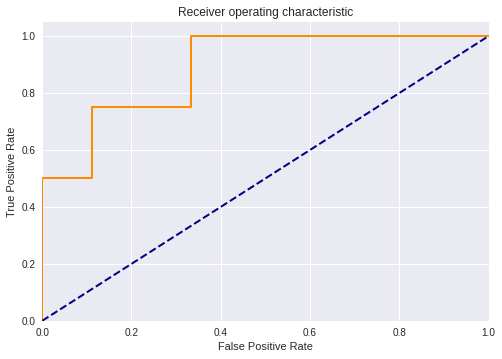

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70,random_state=9)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 

from sklearn.metrics import roc_auc_score
print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=109)
# clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)
print("MCC score : ",matthews_corrcoef(y_test, y_pred))

lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

# print("AUC : ",roc_auc_score(y_test, y_pred, multi_class='ovr'))
lw = 2
plt.figure()
plt.style.use('seaborn')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=9)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred))   


ACCURACY OF THE MODEL:  0.75
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         2
         1.0       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

AUCROC 0.75

ACCURACY OF THE MODEL:  0.75
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         2
         1.0       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

AUCROC 0.75

ACCURACY OF THE MODEL:  0.75
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         2
         1.0       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg  

In [18]:
scores_mcc

[0.5773502691896258,
 0.5773502691896258,
 0.5773502691896258,
 0.5773502691896258,
 0.5773502691896258]

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = SVC(kernel = 'linear',gamma = 'scale', shrinking = False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=9)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 

from sklearn.metrics import roc_auc_score
print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)


ACCURACY OF THE MODEL:  0.75
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         2
         1.0       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

AUCROC 0.75


0.5773502691896258

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=1)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

# print classification report 
print(classification_report(y_test, y_pred)) 

from sklearn.metrics import roc_auc_score
print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)


ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

AUCROC 0.75


0.6324555320336759

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = GaussianNB()


scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=9)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

AUCROC 0.75

ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

AUCROC 0.75

ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy              

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
# creating a RF classifier 
clf =  KNeighborsClassifier(n_neighbors=5)


scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=10)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.6666666666666666
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

AUCROC 0.5

ACCURACY OF THE MODEL:  0.6666666666666666
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

AUCROC 0.5

ACCURACY OF THE MODEL:  0.6666666666666666
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80         4
         1.0       0.00      0.00      0.00         2

    accuracy                

/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py_36_env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cellsearch/py

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = AdaBoostClassifier(n_estimators=1000, random_state=0)

scores_acc = []
scores_mcc = []
scores_auroc = []
scores_macro_f1 = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=9)

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 

    # performing predictions on the test dataset 
    y_pred = clf.predict(X_test) 

    # metrics are used to find accuracy or error 
    from sklearn import metrics   
    print() 

    # using metrics module for accuracy calculation 
    print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
    scores_acc.append(metrics.accuracy_score(y_test, y_pred))

    # print classification report 
    print(classification_report(y_test, y_pred)) 

    from sklearn.metrics import roc_auc_score
    print("AUCROC",roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))
    scores_auroc.append(roc_auc_score(y_test, clf.predict(X_test), multi_class='ovr'))

    from sklearn.metrics import matthews_corrcoef
    matthews_corrcoef(y_test, y_pred)
    scores_mcc.append(matthews_corrcoef(y_test, y_pred)) 


ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

AUCROC 0.75

ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6

AUCROC 0.75

ACCURACY OF THE MODEL:  0.8333333333333334
              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89         4
         1.0       1.00      0.50      0.67         2

    accuracy              

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 1000)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=9)
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
x_pred = clf.predict(X_train) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_train, x_pred)) 

# print classification report 
print(classification_report(y_train, x_pred)) 

from sklearn.metrics import roc_auc_score
print("AUCROC",roc_auc_score(y_train, clf.predict(X_train), multi_class='ovr'))

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

KeyboardInterrupt: 

In [26]:
scores_mcc

[0.0, 0.0, 0.0, 0.0, 0.0]

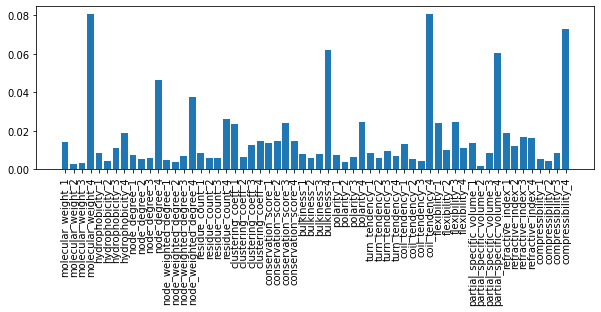

Accuracy: 1.00
0.0


In [9]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestClassifier(n_estimators=1000)
scores=[]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=109)
    # fit the model
    model.fit(X_train, y_train)
    sc = model.score(X_test,y_test)
    scores.append(sc)
#get importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,3))
importance = model.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
y_pos = np.arange(X.shape[1])
pyplot.xticks(y_pos,signals_wavelet, rotation='vertical')
pyplot.show()

scores = np.array(scores)
print("Accuracy: %0.2f" % (scores.mean()))
print(scores.std())

In [12]:
final_data = pd.DataFrame(columns = ['Wavelet Scales','Feature Score','Feature Importance','group'])
# final_data.columns = ['Wavelet Scales','Feature Score','Feature Importance','Feature']
k=0
for i,j in zip(importance,signals_wavelet):
#     print(j.rpartition("_"))
    final_data.loc[k,'Wavelet Scales'] = j.rpartition("_")[2]
    final_data.loc[k,'group'] = j.rpartition("_")[0]
    final_data.loc[k,'Feature Score'] = i
    final_data.loc[k,'Feature Importance'] = i
    k=k+1
final_data.to_csv("./feature_importance_alpha_beta.txt",sep="\t",index=False)

In [87]:
imp_features = importance.argsort()[:10][::-1]
important_features = X.columns[imp_features]
important_features = [x.rsplit("_",1)[0] for x in important_features]
important_features = np.unique(important_features)

In [88]:
important_features

array(['bulkiness', 'clustering_coeff', 'conservation_score',
       'molecular_weight', 'node_degree', 'node_weighted_degree',
       'partial_specific_volume', 'turn_tendency'], dtype='<U23')

In [55]:
disease_data = pd.read_csv("./protein_disease_residue_humsavar.txt",sep="\t")
protein_to_gene = pd.read_csv("./uniprot_protein_to_gene_alphabeta.tab",sep="\t")
protein_to_gene = protein_to_gene.loc[:,['yourlist:M202103258BC4D7ADE02784B0C2481C7F3DE0963A00EB7FS','Gene names']]
protein_to_gene.columns = ['pdb','Gene']
b = pd.DataFrame(protein_to_gene.pdb.str.split(',').tolist(), index=protein_to_gene.Gene).stack()
b = b.reset_index()[[0, 'Gene']]
b.columns = ['pdb', 'Gene']
b = b.dropna()
b = b.reset_index()

In [56]:
gsp_features.index = [i.split('.')[0] for i in gsp_features.index]
gsp_features.index = [i.upper() for i in gsp_features.index]

In [57]:
residue_mutation = pd.DataFrame()
for i in np.unique(b['pdb']):
    gene = []
    indx = np.where(b['pdb'] == i)[0]
    for j in indx:
        gene.extend(b.loc[j,'Gene'].split(" "))
    for k in range(len(gene)):
        ind = np.where(disease_data.loc[:,'Main_gene_name'] == gene[k])[0]
        if len(ind)>0:
            ser = pd.Series(i, index =range(len(ind)))
            n_df = pd.concat([ser,disease_data.loc[ind,['AA_change','Disease name']].reset_index(drop=True)],axis=1)
            residue_mutation = residue_mutation.append(n_df)
residue_mutation['AA_change'] = residue_mutation['AA_change'].str.split(".",expand=True).loc[:,1]
residue_mutation = pd.concat([residue_mutation,residue_mutation['AA_change'].str.split('(\d+)([A-Za-z]+)', expand=True)],axis=1)
residue_mutation.to_csv("./alpha_beta_residue_mutation.txt",sep="\t")

In [58]:
residue_mutation = pd.read_csv("./alpha_beta_residue_mutation.txt",sep="\t")
residue_mutation.columns = ['index','pdb','AA_change','Disease name','Residue','Position','Mutate_to_residue',''] 
res = mutation_find(pdbinfo_dict,residue_mutation,amino_lookup)

In [26]:
from sklearn.neighbors import NearestNeighbors
def get_key(val,my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
def mutation_find(dictionary,residue_mutation,amino_lookup):
    final_neighbors = pd.DataFrame()
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]   
    for k in d1.keys():
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        residues = np.unique([amino_lookup.get(key.upper()) for key in residues])
        for j in residues:
            indices = [m for m,s in enumerate(d1[k]['sequence']) if j in s]
            nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(d1[k]['distance_matrix'])
            distances, indic = nbrs.kneighbors(d1[k]['distance_matrix'])
            ind_find_residue = indic[np.where(np.isin(indic, indices))[0],:]   
            neighbors = np.unique([s for m,s in enumerate(d1[k]['sequence']) if m in np.ravel(ind_find_residue)])
            neighbors = [get_key(m,amino_lookup) for m in neighbors]
            new_row = pd.DataFrame([k,get_key(j,amino_lookup),neighbors]).T
            final_neighbors = final_neighbors.append(new_row)
    return final_neighbors

In [28]:
def mutation_find_replace(dictionary,residue_mutation,amino_lookup):
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('.')[0]
        i1 = i1.upper()
        d1[i1] = dictionary[i]   
    for k in d1.keys():
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        mutation = residue_mutation.loc[indx,'Mutate_to_residue']
        mutation = [amino_lookup.get(key.upper()) for key in mutation]
        residues = [amino_lookup.get(key.upper()) for key in residues]
        seq = list(d1[k]['sequence'])
        for m,j in enumerate(residues):
            indices = [l for l,s in enumerate(d1[k]['sequence']) if j in s]
            for n,i in enumerate(d1[k]['sequence']):
                if n in indices:
                    seq[n] = mutation[m]
                else:
                    seq[n] = d1[k]['sequence'][n]
        seq1 = ''.join(seq)
        d1[k]['sequence'] = seq1
    return d1

In [83]:
def get_filtered_signal_mutation(G, signal, cutoff,type_spatial, indices):
    if type_spatial == 'fourier':
        gftsignal = G.gft(signal)
        signal_hat = gftsignal
        value = np.sum(abs(signal_hat[G.e < G.lmax*cutoff])) / np.sum(abs(signal_hat))
        return value
    elif type_spatial == 'wavelet':
        N_f=4
        scales = utils.compute_log_scales(1, len(signal), N_f-1)
        mex = filters.Abspline(G, Nf=N_f,scales=scales)
        signal_filtered_hat = mex.filter(signal)
        signal_filtered_hat = np.abs(signal_filtered_hat)
        signal_filtered_hat1 = np.zeros([1,signal_filtered_hat.shape[1]])
#         print(signal_filtered_hat1.shape)
        for j in range(signal_filtered_hat.shape[1]):
            p = np.percentile(signal_filtered_hat[:,j], 70) 
            signal_filtered_hat[np.where(signal_filtered_hat[:,j]<p),j] = 0
            b = [stats.percentileofscore(signal_filtered_hat[:,j], a, 'rank') for a in signal_filtered_hat[:,j]]
            signal_filtered_hat[:,j] = b
            signal_filtered_hat1[:,j] = signal_filtered_hat[indices,j] 
#         print(signal_filtered_hat1)
        signal_filtered_hat1 = np.mean(np.abs(signal_filtered_hat1))
        return signal_filtered_hat1
    
def mutation_find_wavelet_coefficient(dictionary,residue_mutation,amino_lookup,signal_important,cutoff,type_spatial):
    residue_mutation['pdb'] = [x.upper() for x in residue_mutation['pdb']]
#     print(residue_mutation['pdb'])
    keys = dictionary.keys()
    d1 = {}
    for i in keys:
        i1 = i.split('_')[1]
        i1 = i1.upper()
        d1[i1] = dictionary[i]  
    G = {}
    for pdb in d1.keys():
        try:
            G[pdb] = get_graph(d1[pdb]['distance_matrix'], network_type=model, rig_cutoff=7.3)
        except:
            continue  
#     print(G.keys())
    coeff_final = {}
    for k in d1.keys():
#         coeff_final[k] = {}
#         print(k)
        indx = np.where(residue_mutation['pdb'] == k)[0]
        residues = residue_mutation.loc[indx,'Residue']
        residues = [amino_lookup.get(key.upper()) for key in residues]
        pos = np.array(residue_mutation.loc[indx,'Position'])
        dis = np.array(residue_mutation.loc[indx,'Disease name'])
#         print(residues)
#         residues = np.unique(residues)
        G1 = G[k]
        for m,j in enumerate(residues):
#             print(j)
#             indices = [l for l,s in enumerate(d1[k]['sequence']) if j in s]
#             print(indices)
            indices = pos[m]
            try:
                if np.array(list(d1[k]['sequence']))[indices] == j: 
                    coeff_final[k,j,pos[m],dis[m]] = {}
                    for i in signal_important:
                        try:
                            coeff_final[k,j,pos[m],dis[m]][i] = {}
                            signal = get_signal(G1, d1[k]['sequence'],k,signal=i)
                            coeff1 = get_filtered_signal_mutation(G1, signal, cutoff, type_spatial, indices)
            #                 print(coeff1)
                            coeff_final[k,j,pos[m],dis[m]][i] = coeff1    
                        except:
                            if coeff_final[k,j,pos[m],dis[m]][i] == {}:
                                del coeff_final[k,j,pos[m],dis[m]][i] 
                    if coeff_final[k,j,pos[m],dis[m]] == {}:
                                del coeff_final[k,j,pos[m],dis[m]]  
            except:
                traceback.print_exc()
    return coeff_final

In [89]:
from scipy import stats
import traceback
cutoff=70
type_spatial='wavelet'
network_type = 'weighted-rig'
res = mutation_find_wavelet_coefficient(pdbinfo_dict,residue_mutation,amino_lookup,important_features,cutoff,type_spatial)

Traceback (most recent call last):
  File "<ipython-input-83-e2c3b28de009>", line 59, in mutation_find_wavelet_coefficient
    if np.array(list(d1[k]['sequence']))[indices] == j:
IndexError: index 208 is out of bounds for axis 0 with size 81
Traceback (most recent call last):
  File "<ipython-input-83-e2c3b28de009>", line 59, in mutation_find_wavelet_coefficient
    if np.array(list(d1[k]['sequence']))[indices] == j:
IndexError: index 254 is out of bounds for axis 0 with size 126
Traceback (most recent call last):
  File "<ipython-input-83-e2c3b28de009>", line 59, in mutation_find_wavelet_coefficient
    if np.array(list(d1[k]['sequence']))[indices] == j:
IndexError: index 215 is out of bounds for axis 0 with size 108
Traceback (most recent call last):
  File "<ipython-input-83-e2c3b28de009>", line 59, in mutation_find_wavelet_coefficient
    if np.array(list(d1[k]['sequence']))[indices] == j:
IndexError: index 86 is out of bounds for axis 0 with size 86
Traceback (most recent call las

In [91]:
pd.DataFrame(res).to_csv("./alpha_beta_mutation_results.txt",sep="\t")

In [90]:
res

{('1YCC', 'L', 89, '-'): {'bulkiness': 62.03703703703704,
  'clustering_coeff': 59.72222222222222,
  'conservation_score': 60.87962962962963,
  'molecular_weight': 35.18518518518518,
  'node_degree': 49.074074074074076,
  'node_weighted_degree': 47.222222222222214,
  'partial_specific_volume': 43.98148148148148,
  'turn_tendency': 71.29629629629629}}